In [1]:
# 차분 한거
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------
# 1. 데이터 로딩
# -------------------------------
path = "../../preprocessing/log공선성제거_Final_data.csv"
df = pd.read_csv(path)

# y_target_log 차분 → ret_prev
df["ret_prev"] = (df["y_target_log"] - df["y_target_log"].shift(1))

# Date가 있으면 시계열 정렬
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

# 첫 번째 차분에서 생긴 NaN 제거
df = df.dropna(subset=["ret_prev"]).reset_index(drop=True)

# -------------------------------
# 2. Feature / Target 분리
# -------------------------------
target_col = "ret_prev"   # 예: 로그 수익률
drop_cols = ["Date", target_col, "y_target_log"]

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].select_dtypes(include=[np.number])
y = df[target_col]

df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print("최종 사용 행 개수:", len(X))
print("사용 피처 수:", X.shape[1])

date_all = df.loc[df_clean.index, "Date"].reset_index(drop=True)

최종 사용 행 개수: 753
사용 피처 수: 5


Train Val Test 분리 + RMSE, R2

In [2]:
# -------------------------------
# 3. Train / Val / Test Split
# -------------------------------
n = len(X)

test_size = int(n * 0.20)
remaining = n - test_size
val_size = int(remaining * 0.20)
train_size = remaining - val_size

print(f"train: {train_size}, val: {val_size}, test: {test_size}")

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size : train_size + val_size]
y_val = y.iloc[train_size : train_size + val_size]

X_test = X.iloc[train_size + val_size :]
y_test = y.iloc[train_size + val_size :]

print("분할 결과:", len(X_train), len(X_val), len(X_test))

train: 483, val: 120, test: 150
분할 결과: 483 120 150


In [3]:
# -------------------------------
# 4. 다중 회귀 모델 학습 및 예측
# -------------------------------

# Linear Regression 모델 학습
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Test set 예측 (차분 값 예측)
y_test_pred_reg = reg_model.predict(X_test)

# 예측 결과를 Series 형태로 변환 (시각화 코드와 일관성을 위해)
y_test_pred_reg = pd.Series(y_test_pred_reg, index=y_test.index)

print(f"모델 학습 완료. Test 예측값 길이: {len(y_test_pred_reg)}")

모델 학습 완료. Test 예측값 길이: 150


Test 예측 vs 실제값 차분 안 푼거 시각화

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_name = 'Malgun Gothic' 

# 폰트 설정
plt.rc('font', family=font_name)

# 마이너스 기호가 깨지는 거 방지
plt.rcParams['axes.unicode_minus'] = False

print("VS Code Matplotlib 한글 설정 완료 (NanumGothic)")

VS Code Matplotlib 한글 설정 완료 (NanumGothic)


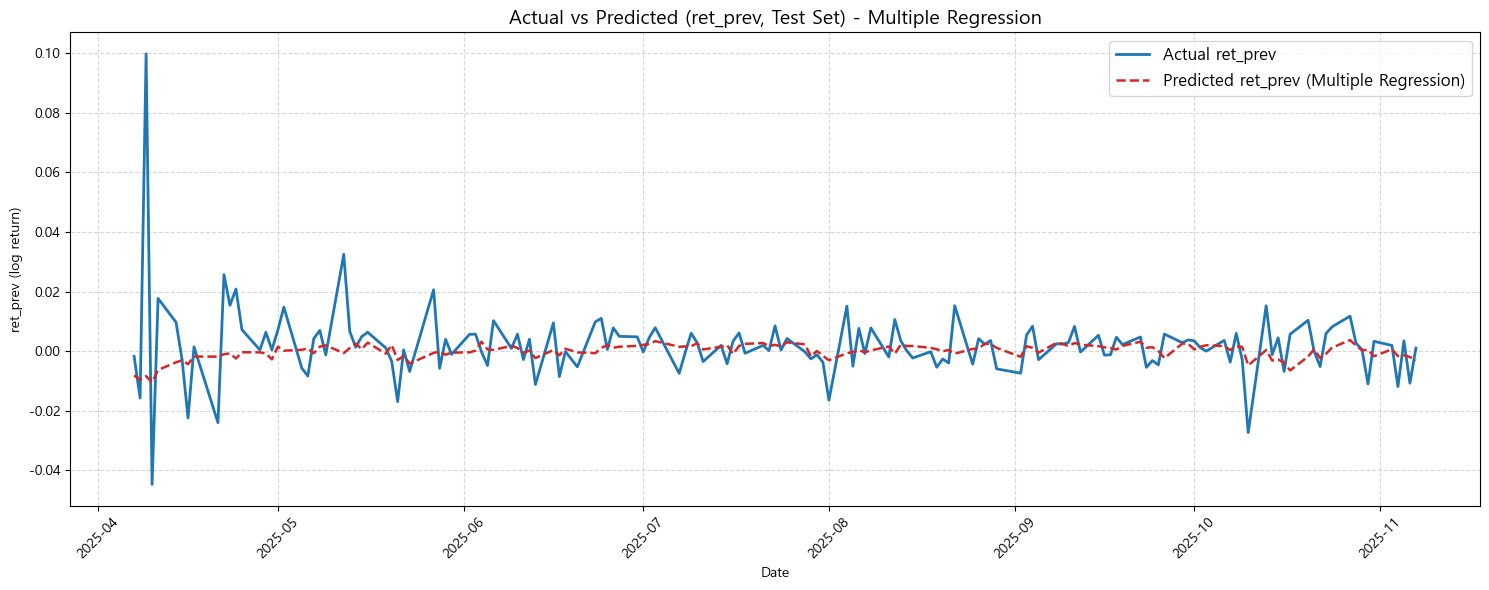

In [5]:
# -------------------------------------------
# A. 차분 값 (ret_prev) 시각화
# -------------------------------------------

# 테스트 구간 날짜
test_dates_diff = date_all.iloc[train_size + val_size :].reset_index(drop=True)

# 시각화를 위한 DataFrame 생성
comparison_df = pd.DataFrame(
    {
        "Actual": y_test.to_numpy(),            # 실제 ret_prev
        "Prediction": y_test_pred_reg.to_numpy() # 예측 ret_prev
    },
    index=test_dates_diff
)
comparison_df.index.name = "Date"

# 시계열 비교 플롯 (차분 값)
plt.figure(figsize=(15, 6))

plt.plot(
    comparison_df.index,
    comparison_df["Actual"],
    label="Actual ret_prev",
    color="#1f77b4",
    linewidth=2
)

plt.plot(
    comparison_df.index,
    comparison_df["Prediction"],
    label="Predicted ret_prev (Multiple Regression)",
    color="#d62728",
    linestyle="--",
    linewidth=1.8
)

plt.title("Actual vs Predicted (ret_prev, Test Set) - Multiple Regression", fontsize=14)
plt.xlabel("Date")
plt.ylabel("ret_prev (log return)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# -------------------------------
# 4. 다중 회귀 모델 학습 및 예측
# -------------------------------

# Linear Regression 모델 학습
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Test set 예측 (차분 값 예측)
y_test_pred_reg = reg_model.predict(X_test)

# 예측 결과를 Series 형태로 변환 (시각화 코드와 일관성을 위해)
y_test_pred_reg = pd.Series(y_test_pred_reg, index=y_test.index)

print(f"모델 학습 완료. Test 예측값 길이: {len(y_test_pred_reg)}")

모델 학습 완료. Test 예측값 길이: 150


차분 푼거 시각화

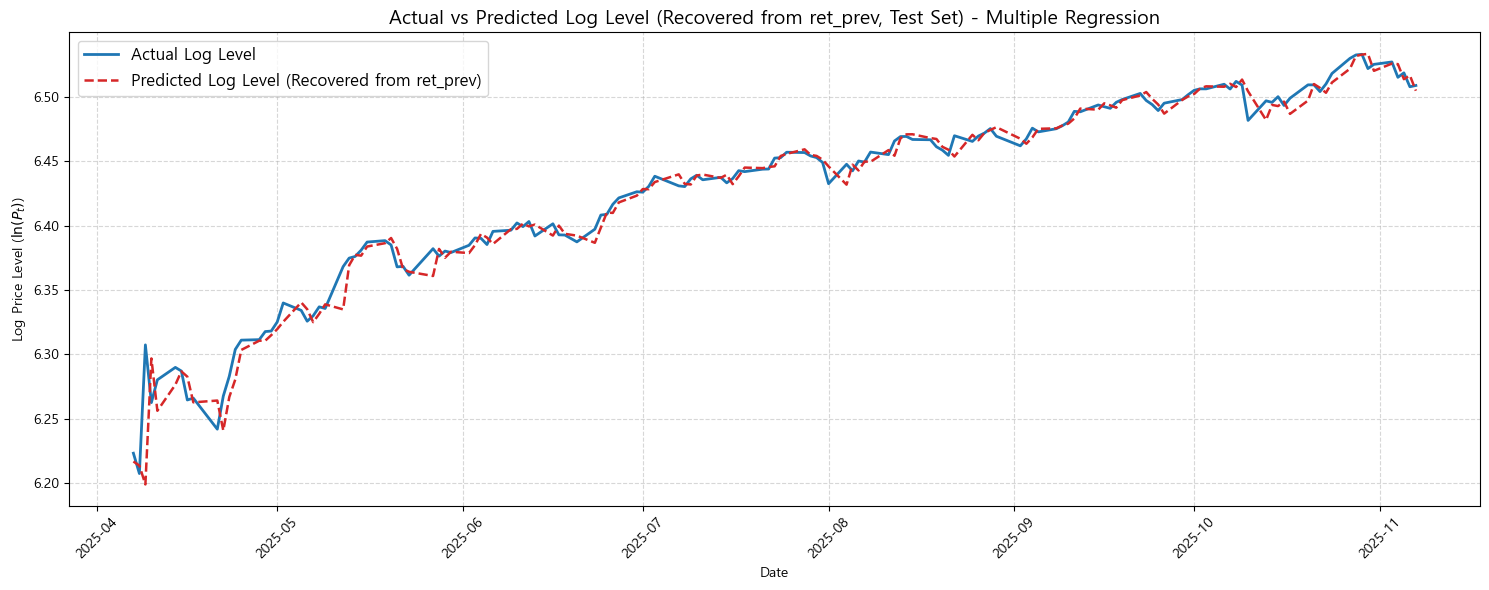

In [7]:
# -------------------------------------------
# B. 로그 레벨 값 (Level) 복원 및 시각화
# -------------------------------------------

n_test = len(y_test)
test_start_idx = train_size + val_size

# 1. df_clean에 맞춘 y_target_log 전체 (로그 레벨)
# df_clean의 인덱스를 사용하여 원본 df에서 y_target_log를 가져옴
y_log_all = df.loc[df_clean.index, "y_target_log"].reset_index(drop=True)


# 2. test 구간의 실제 log 레벨 ($\ln(P_t^{\text{real}})$)
log_true = y_log_all.iloc[test_start_idx : test_start_idx + n_test].reset_index(drop=True)

# 3. test 구간 **직전 시점**의 실제 log 레벨 ($\ln(P_{t-1}^{\text{real}})$)
# df_clean은 차분 때문에 첫 행이 제거된 상태이므로, 직전 시점은 test_start_idx - 1
log_prev = y_log_all.iloc[test_start_idx - 1 : test_start_idx - 1 + n_test].reset_index(drop=True)

# 4. 예측된 차분(ret_prev)을 이용해 log 레벨 복원 코드를 다음과 같이 명확히 수정

# log_prev는 Series여야 함
log_prev = y_log_all.iloc[test_start_idx - 1 : test_start_idx - 1 + n_test].reset_index(drop=True)

# y_test_pred_reg는 np.array 또는 Series. 안전하게 np.array로 변환하여 더함
log_pred_array = log_prev.values + y_test_pred_reg.values # .values를 사용하여 인덱스 무시하고 값만 더함

# 5. 로그 레벨 비교용 DataFrame 생성 시 array 사용
comparison_log_df = pd.DataFrame(
    {
        "Actual_Level": log_true.to_numpy(),
        "Pred_Level": log_pred_array, # array 사용
    },
    index=test_dates_diff
)
comparison_log_df.index.name = "Date"
comparison_log_df.index = pd.to_datetime(comparison_log_df.index) # 날짜 형식 보장
comparison_log_df = comparison_log_df.sort_index()

# -------------------------------------------
# 6. 레벨(로그 가격) 시계열 비교 플롯
# -------------------------------------------
plt.figure(figsize=(15, 6))

plt.plot(
    comparison_log_df.index,
    comparison_log_df["Actual_Level"],
    label="Actual Log Level",
    color="#1f77b4",
    linewidth=2
)

plt.plot(
    comparison_log_df.index,
    comparison_log_df["Pred_Level"],
    label="Predicted Log Level (Recovered from ret_prev)",
    color="#d62728",
    linestyle="--",
    linewidth=1.8
)

plt.title("Actual vs Predicted Log Level (Recovered from ret_prev, Test Set) - Multiple Regression", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Log Price Level ($\ln(P_t)$)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# -------------------------------
# 4. 다중 회귀 모델 학습 및 예측
# -------------------------------

# Linear Regression 모델 학습
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Test set 예측 (차분 값 예측)
y_test_pred_reg = reg_model.predict(X_test)

# 예측 결과를 Series 형태로 변환 (시각화 코드와 일관성을 위해)
y_test_pred_reg = pd.Series(y_test_pred_reg, index=y_test.index)

print(f"모델 학습 완료. Test 예측값 길이: {len(y_test_pred_reg)}")

모델 학습 완료. Test 예측값 길이: 150


차분 안 푼거 잔차 그래프

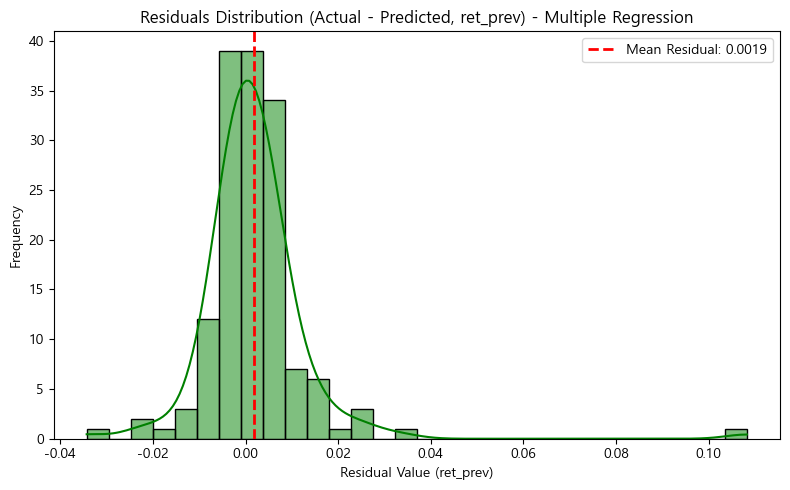

In [9]:
# =================================
# 잔차 시각화 (Residuals Plot)
# =================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 잔차 계산 (ret_prev = 로그수익률 기준)
# y_test : 실제값 (Series)
# y_test_pred_reg : 예측값 (Series/array)
# y_test.values : 실제값 (numpy array)
# y_test_pred_reg.values : 예측값 (numpy array, Series로 변환했을 경우)
# 예측값이 ndarray라면 .values는 불필요하지만, 통일성을 위해 Series로 변환한 y_test_pred_reg를 사용
residuals_reg = y_test.values - y_test_pred_reg.values 

# 2. 잔차 시각화
plt.figure(figsize=(8, 5))
sns.histplot(residuals_reg, bins=30, kde=True, color='green', edgecolor='black')

plt.title('Residuals Distribution (Actual - Predicted, ret_prev) - Multiple Regression')
plt.xlabel('Residual Value (ret_prev)')
plt.ylabel('Frequency')

# 잔차 평균 수직선
mean_resid = residuals_reg.mean()
plt.axvline(
    mean_resid,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Mean Residual: {mean_resid:.4f}'
)
plt.legend()
plt.tight_layout()
plt.show()

차분 푼거 잔차 그래프

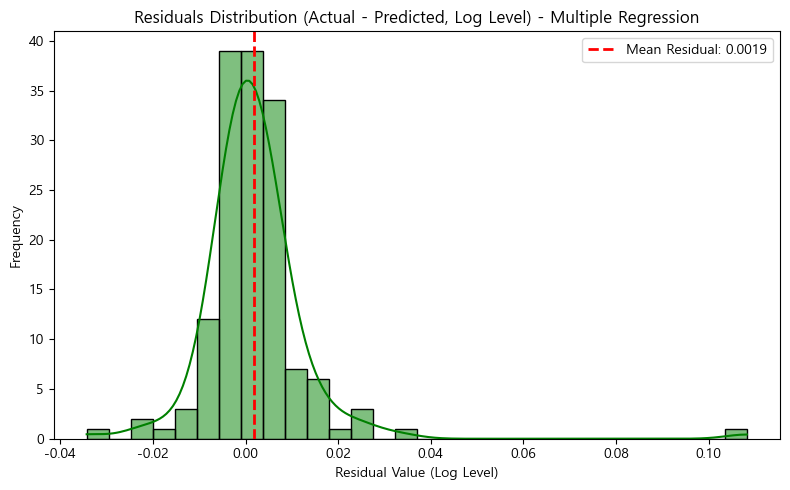

In [10]:
# =================================
# 잔차 시각화 (Log Level Residuals Plot)
# =================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 'B. 로그 레벨 값 (Level) 복원 및 시각화' 섹션에서 생성된 comparison_log_df 사용

# 1. 로그 레벨 잔차 계산
# 잔차 = 실제 레벨 - 예측 레벨
# comparison_log_df는 이전 코드 블록에서 다음과 같은 열을 가지고 있어야 함:
# "Actual_Level", "Pred_Level"
residuals_log_level = comparison_log_df["Actual_Level"].values - comparison_log_df["Pred_Level"].values

# 2. 잔차 시각화
plt.figure(figsize=(8, 5))
# 색상: 주황색 (#ff7f0e)을 사용하여 ret_prev 잔차(녹색)와 구분합니다.
sns.histplot(residuals_log_level, bins=30, kde=True, color='green', edgecolor='black') 

plt.title('Residuals Distribution (Actual - Predicted, Log Level) - Multiple Regression')
plt.xlabel('Residual Value (Log Level)')
plt.ylabel('Frequency')

# 잔차 평균 수직선
mean_resid_level = residuals_log_level.mean()
plt.axvline(
    mean_resid_level,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Mean Residual: {mean_resid_level:.4f}'
)
plt.legend()
plt.tight_layout()
plt.show()

최적 seq_len 찾고 모델 돌리기

In [11]:
# ============================================================
# 7. seq_len 탐색 (다중회귀 + 슬라이딩 윈도우 피처)
#    - seq_len 길이만큼 과거 피처를 이어붙여 하나의 벡터로 만들어
#      LinearRegression에 넣고, Validation RMSE가 최소인 seq_len을 찾음
# ============================================================

# 7-1. seq_len용 전체 스케일링
# (엄밀하게는 train구간만으로 맞추는 게 더 좋지만,
#  여기서는 구현 단순화를 위해 전체 구간 기준으로 스케일링)
scaler_seq = MinMaxScaler()
X_all_scaled = scaler_seq.fit_transform(X.values)  # (n_samples, n_features)
y_all = y.values                                   # (n_samples,)

print("\n[seq_len 탐색용 스케일링 완료]")
print("X_all_scaled shape:", X_all_scaled.shape)
print("y_all shape:", y_all.shape)

# 7-2. 시퀀스 데이터셋 생성 함수 (LSTM이 아니라 다중회귀용)
def make_seq_dataset_for_reg(X_array, y_array, seq_len):
    """
    X_array: (N, num_features)
    y_array: (N,)
    seq_len 기간만큼 window를 만들어,
      X_seq: (num_samples, seq_len, num_features)
      y_seq: (num_samples,)
    를 반환. 타깃은 window의 마지막 시점 y.
    """
    X_list = []
    y_list = []
    for i in range(len(X_array) - seq_len + 1):
        X_list.append(X_array[i : i + seq_len])
        y_list.append(y_array[i + seq_len - 1])
    return np.array(X_list), np.array(y_list)

# 7-3. seq_len 후보 정의 (1~50)
candidate_seq_lens = list(range(1, 51))

best_seq_len   = None
best_val_rmse  = np.inf
best_model_seq = None

for seq_len in candidate_seq_lens:
    # 1) 시퀀스 데이터 생성
    X_seq, y_seq = make_seq_dataset_for_reg(X_all_scaled, y_all, seq_len)
    n_samples = len(X_seq)

    if n_samples < 10:
        print(f"seq_len={seq_len} → 샘플 수 부족 (n={n_samples}), 스킵")
        continue

    # 2) Train / Val / Test 분할
    test_size = int(n_samples * 0.20)                # test 20%
    remaining = n_samples - test_size                # 남은 80%
    val_size = int(remaining * 0.20)                 # val = 0.2 * 0.8 = 0.16
    train_size = remaining - val_size                # train = 0.8 - 0.16 = 0.64

    train_end = train_size
    val_end = train_size + val_size

    # 데이터 분할 크기 출력
    print(f"[seq_len={seq_len}] 데이터 분할")
    print(f" - 전체 샘플 수 : {n_samples}")
    print(f" - Train 개수   : {train_size} ({train_size/n_samples:.3f})")
    print(f" - Val 개수     : {val_size} ({val_size/n_samples:.3f})")
    print(f" - Test 개수    : {test_size} ({test_size/n_samples:.3f})")
    print("-" * 40)

    # 3D → 2D
    X_train_seq = X_seq[:train_end].reshape(train_size, -1)
    y_train_seq = y_seq[:train_end]

    X_val_seq   = X_seq[train_end:val_end].reshape(val_size, -1)
    y_val_seq   = y_seq[train_end:val_end]

    X_test_seq  = X_seq[val_end:].reshape(test_size, -1)
    y_test_seq  = y_seq[val_end:]

    # 3) 다중회귀 모델 생성 및 학습
    model_seq = LinearRegression()
    model_seq.fit(X_train_seq, y_train_seq)

    # 4) Validation 성능 계산 (RMSE 기준)
    y_val_pred_seq = model_seq.predict(X_val_seq)
    val_rmse_seq = np.sqrt(mean_squared_error(y_val_seq, y_val_pred_seq))

    print(f"seq_len={seq_len} → Validation RMSE={val_rmse_seq:.6f}")

    # 5) 최적 seq_len 갱신
    if val_rmse_seq < best_val_rmse:
        best_val_rmse = val_rmse_seq
        best_seq_len  = seq_len
        best_model_seq = model_seq
print("\n 다중회귀 기준 최적 seq_len:", best_seq_len)
print(f"그때의 Validation RMSE: {best_val_rmse:.6f}")


[seq_len 탐색용 스케일링 완료]
X_all_scaled shape: (753, 5)
y_all shape: (753,)
[seq_len=1] 데이터 분할
 - 전체 샘플 수 : 753
 - Train 개수   : 483 (0.641)
 - Val 개수     : 120 (0.159)
 - Test 개수    : 150 (0.199)
----------------------------------------
seq_len=1 → Validation RMSE=0.010809
[seq_len=2] 데이터 분할
 - 전체 샘플 수 : 752
 - Train 개수   : 482 (0.641)
 - Val 개수     : 120 (0.160)
 - Test 개수    : 150 (0.199)
----------------------------------------
seq_len=2 → Validation RMSE=0.010331
[seq_len=3] 데이터 분할
 - 전체 샘플 수 : 751
 - Train 개수   : 481 (0.640)
 - Val 개수     : 120 (0.160)
 - Test 개수    : 150 (0.200)
----------------------------------------
seq_len=3 → Validation RMSE=0.010421
[seq_len=4] 데이터 분할
 - 전체 샘플 수 : 750
 - Train 개수   : 480 (0.640)
 - Val 개수     : 120 (0.160)
 - Test 개수    : 150 (0.200)
----------------------------------------
seq_len=4 → Validation RMSE=0.010347
[seq_len=5] 데이터 분할
 - 전체 샘플 수 : 749
 - Train 개수   : 480 (0.641)
 - Val 개수     : 120 (0.160)
 - Test 개수    : 149 (0.199)
----------------

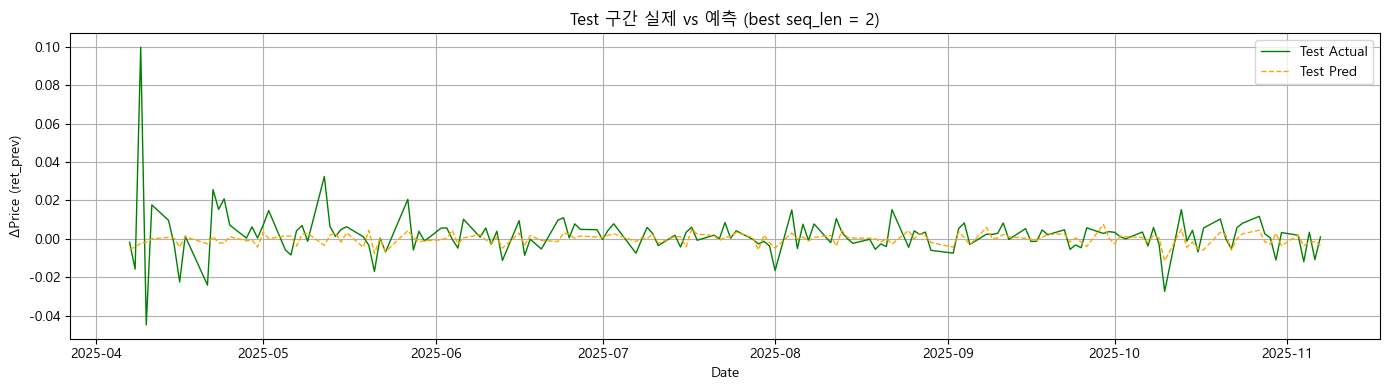

In [12]:
# ================== 4. 최적 seq_len 기준 Test 구간 시각화 ==================
import matplotlib.pyplot as plt  # 위에서 이미 import 했으면 생략

# Date 인덱스에서 전체 날짜 시리즈 생성 (X와 같은 인덱스 기준)
if 'date_all' not in globals():
    date_all = df.loc[X.index, "Date"].reset_index(drop=True)

if (best_model_seq is not None) and (best_seq_len is not None):
    seq_len = best_seq_len

    # 1) 최적 seq_len으로 전체 시퀀스 다시 생성
    #    → seq_len 탐색 때와 동일하게 X_all_scaled / y_all 사용
    X_seq_all, y_seq_all = make_seq_dataset_for_reg(X_all_scaled, y_all, seq_len)
    n_samples = len(X_seq_all)

    # 시퀀스 마지막 시점에 대응하는 날짜 (타깃 y와 정렬)
    date_seq_all = date_all.iloc[seq_len - 1 : seq_len - 1 + n_samples].reset_index(drop=True)

    # 2) Train / Valid / Test 분할 (seq_len 탐색 때와 같은 규칙)
    test_size  = int(n_samples * 0.20)
    remaining  = n_samples - test_size
    valid_size = int(remaining * 0.20)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    # Test 구간만 추출
    X_test_seq   = X_seq_all[valid_end:].reshape(test_size, -1)
    y_test_seq   = y_seq_all[valid_end:]
    date_test_seq = date_seq_all[valid_end:]

    # 3) 최적 모델로 Test 예측
    y_test_pred_best = best_model_seq.predict(X_test_seq)

    # 4) 시각화 (Test 구간만)
    plt.figure(figsize=(14, 4))
    plt.plot(date_test_seq, y_test_seq,
             label="Test Actual",  color="green", linewidth=1)
    plt.plot(date_test_seq, y_test_pred_best,
             label="Test Pred",    color="orange", linestyle="--", linewidth=1)

    plt.title(f"Test 구간 실제 vs 예측 (best seq_len = {best_seq_len})")
    plt.xlabel("Date")
    plt.ylabel("ΔPrice (ret_prev)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("최적 seq_len 모델이 없어 Test 비교 그래프를 그릴 수 없습니다.")


최적 seq_len 차분 풀기

In [13]:
# ============================================================
# 8. 최적 seq_len으로 최종 다중회귀 학습 + 차분 → log level 복원
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n--- 최적 seq_len 기준 최종 모델 학습 및 log level 복원 시작 ---")

price_col = "y_target_log"

# 8-1. 로그 레벨 전체 시계열 (X_all_scaled / y_all 과 같은 인덱스 기준)
y_log_all = df.loc[df_clean.index, price_col].reset_index(drop=True)
date_all  = df.loc[df_clean.index, "Date"].reset_index(drop=True)

# 8-2. 최적 seq_len으로 시퀀스 다시 생성
X_seq_all, y_seq_all = make_seq_dataset_for_reg(X_all_scaled, y_all, best_seq_len)
n_samples = len(X_seq_all)

test_size = int(n_samples * 0.20)
remaining = n_samples - test_size
val_size = int(remaining * 0.20)
train_size = remaining - val_size

train_end = train_size
val_end   = train_size + val_size

print(f"[best_seq_len={best_seq_len}] 재분할 정보")
print(f" - 전체 시퀀스 수 : {n_samples}")
print(f" - Train : {train_size}")
print(f" - Val   : {val_size}")
print(f" - Test  : {test_size}")

# 3D → 2D
X_train_seq = X_seq_all[:train_end].reshape(train_size, -1)
y_train_seq = y_seq_all[:train_end]

X_val_seq   = X_seq_all[train_end:val_end].reshape(val_size, -1)
y_val_seq   = y_seq_all[train_end:val_end]

X_test_seq  = X_seq_all[val_end:].reshape(test_size, -1)
y_test_seq  = y_seq_all[val_end:]

# 8-3. 최적 seq_len 기준 최종 다중회귀 학습
best_seq_model = LinearRegression()
best_seq_model.fit(X_train_seq, y_train_seq)

# (옵션) ret_prev 기준 성능 확인
y_test_pred_best = best_seq_model.predict(X_test_seq)

rmse_ret = np.sqrt(mean_squared_error(y_test_seq, y_test_pred_best))
r2_ret   = r2_score(y_test_seq, y_test_pred_best)

print("\n[최적 seq_len 기준 ret_prev(Test) 성능]")
print(f"RMSE (ret_prev): {rmse_ret:.6f}")
print(f"R^2  (ret_prev): {r2_ret:.6f}")

# ============================================================
# 9. seq_len 최적 모델 기준 차분 → log level 복원
#    ret_prev[t] = logP[t] - logP[t-1] 가정
#    → logP_pred[t] = logP_true[t-1] + ret_prev_pred[t]
# ============================================================

print("\n--- seq_len 기반 차분 → 로그 레벨 복원 시작 ---")

# 9-1. test 시퀀스 인덱스가 원래 시계열에서 가리키는 시점 계산
#      시퀀스 s 의 타깃은 원래 인덱스 (s + best_seq_len - 1)
test_seq_idx = np.arange(val_end, n_samples)           # 길이 = test_size
orig_pos_test = test_seq_idx + best_seq_len - 1        # 0 ~ (N-1) 범위

print("orig_pos_test 범위:", orig_pos_test[0], "→", orig_pos_test[-1])

# 9-2. log level ground truth & 직전 log level
log_true_seq = y_log_all.iloc[orig_pos_test].to_numpy()      # logP[t]
log_prev_seq = y_log_all.iloc[orig_pos_test - 1].to_numpy()  # logP[t-1]

# 9-3. 예측된 ret_prev 로부터 log level 복원
ret_pred_seq = y_test_pred_best.reshape(-1)                  # (test_size,)
log_pred_seq = log_prev_seq + ret_pred_seq                   # logP_pred[t]

# 9-4. 로그 레벨 기준 성능 계산
rmse_seq_log = np.sqrt(mean_squared_error(log_true_seq, log_pred_seq))
mae_seq_log  = mean_absolute_error(log_true_seq, log_pred_seq)
r2_seq_log   = r2_score(log_true_seq, log_pred_seq)

print("\n=== seq_len 기반 로그 레벨 복원 Test 성능 ===")
print(f"best_seq_len : {best_seq_len}")
print(f"RMSE (log)   : {rmse_seq_log:.6f}")
print(f"MAE  (log)   : {mae_seq_log:.6f}")
print(f"R^2  (log)   : {r2_seq_log:.6f}")
print("====================================================")

# 9-5. 시각화용 DataFrame
date_seq_test = date_all.iloc[orig_pos_test].reset_index(drop=True)

result_seq_log = pd.DataFrame({
    "Date": date_seq_test,
    "log_true": log_true_seq,
    "log_pred": log_pred_seq
}).set_index("Date")

print("\n--- seq_len 기반 log-level 복원 결과 (앞 5개) ---")
print(result_seq_log.head())



--- 최적 seq_len 기준 최종 모델 학습 및 log level 복원 시작 ---
[best_seq_len=2] 재분할 정보
 - 전체 시퀀스 수 : 752
 - Train : 482
 - Val   : 120
 - Test  : 150

[최적 seq_len 기준 ret_prev(Test) 성능]
RMSE (ret_prev): 0.011876
R^2  (ret_prev): 0.032775

--- seq_len 기반 차분 → 로그 레벨 복원 시작 ---
orig_pos_test 범위: 603 → 752

=== seq_len 기반 로그 레벨 복원 Test 성능 ===
best_seq_len : 2
RMSE (log)   : 0.011876
MAE  (log)   : 0.006421
R^2  (log)   : 0.974056

--- seq_len 기반 log-level 복원 결과 (앞 5개) ---
            log_true  log_pred
Date                          
2025-04-07  6.223330  6.219574
2025-04-08  6.207543  6.219060
2025-04-09  6.307406  6.205303
2025-04-10  6.262598  6.305623
2025-04-11  6.280283  6.262607


최적 seq_len test부분 시각화

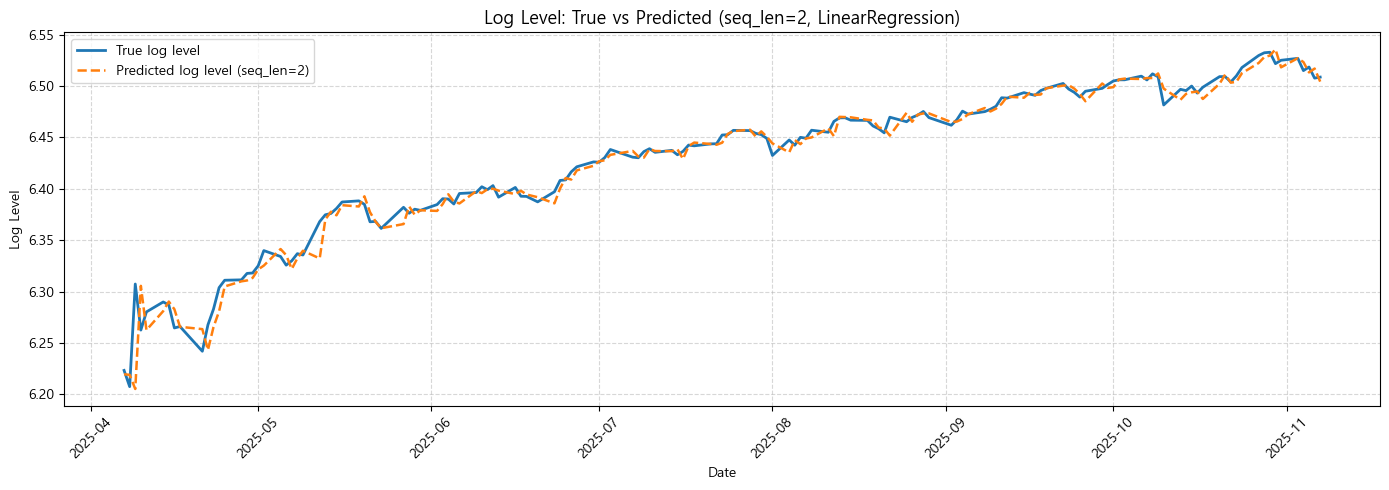

In [14]:
# ============================================================
# 10. seq_len 기반 log-level 복원 결과 시각화
# ============================================================

plt.figure(figsize=(14, 5))
plt.plot(
    result_seq_log.index,
    result_seq_log["log_true"],
    label="True log level",
    linewidth=2
)
plt.plot(
    result_seq_log.index,
    result_seq_log["log_pred"],
    label=f"Predicted log level (seq_len={best_seq_len})",
    linestyle="--",
    linewidth=1.8
)
plt.title(f"Log Level: True vs Predicted (seq_len={best_seq_len}, LinearRegression)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Log Level")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

seq_len 결과 저장

In [15]:
# ============================================================
# 11. seq_len 복원 성능 → CSV 저장
# ============================================================

save_path_seq_metrics = "../../modeling/성능지표/SPY_다중회귀_지표.csv"

metrics_for_save = pd.DataFrame({
    "SPY_다중회귀_RMSE": [rmse_seq_log],   # 로그 기준 RMSE
    "SPY_다중회귀_MAE":  [mae_seq_log],      # 로그 기준 MAE
    "SPY_다중회귀_R2":   [r2_seq_log],     # 로그 기준 R²
})

metrics_for_save.to_csv(save_path_seq_metrics, index=False, encoding="utf-8-sig")

print("\nCSV 저장 완료:", save_path_seq_metrics)
print(metrics_for_save)



CSV 저장 완료: ../../modeling/성능지표/SPY_다중회귀_지표.csv
   SPY_다중회귀_RMSE  SPY_다중회귀_MAE  SPY_다중회귀_R2
0       0.011876      0.006421     0.974056


In [16]:
import joblib
import os

# ----------------------------------------------------
# 1. 모델 저장 (모델 학습 후)
# ----------------------------------------------------

# 저장할 디렉토리와 파일명 설정
# 모델 이름에 최적 seq_len을 포함시켜 구별하기 용이하게 합니다.
model_dir = "../../modeling/Model/"
model_filename = f"다중회귀_best.joblib"
model_path = os.path.join(model_dir, model_filename)

# 모델 디렉토리가 없다면 생성
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 모델 저장
joblib.dump(best_seq_model, model_path)

print(f"\n최종 다중회귀 모델이 성공적으로 저장되었습니다.")
print(f"   경로: {model_path}")


최종 다중회귀 모델이 성공적으로 저장되었습니다.
   경로: ../../modeling/Model/다중회귀_best.joblib


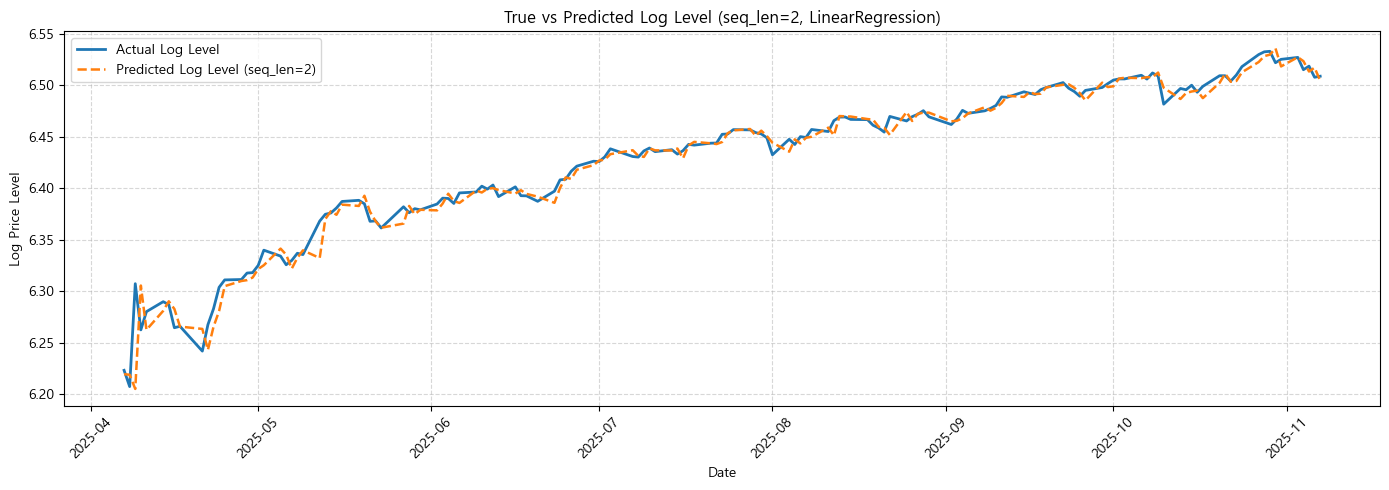

In [18]:
# Actual vs Predicted (True vs Predicted) - 로그 라베 기준
# ============================================================
# 1) Actual vs Predicted (True vs Predicted) - Log Level 기준
# ============================================================

plt.figure(figsize=(14, 5))
plt.plot(
    result_seq_log.index,
    result_seq_log["log_true"],
    label="Actual Log Level",
    linewidth=2,
)
plt.plot(
    result_seq_log.index,
    result_seq_log["log_pred"],
    label=f"Predicted Log Level (seq_len={best_seq_len})",
    linestyle="--",
    linewidth=1.8,
)

plt.title(f"True vs Predicted Log Level (seq_len={best_seq_len}, LinearRegression)")
plt.xlabel("Date")
plt.ylabel("Log Price Level")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

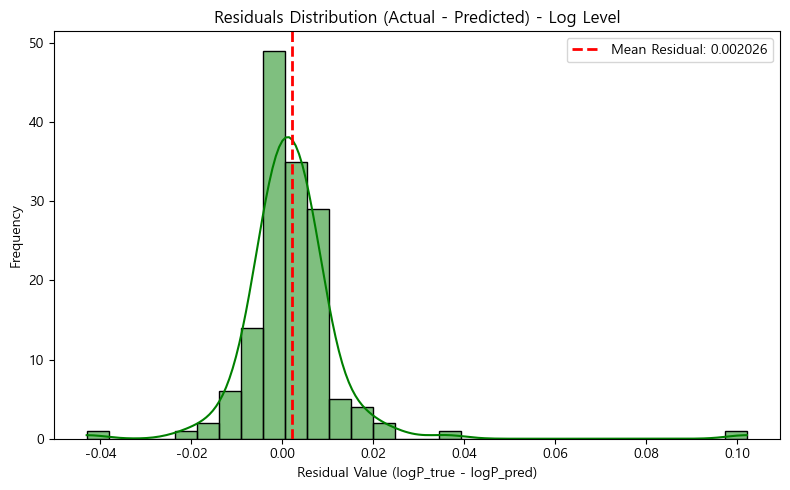

In [19]:
# ============================================================
# 2) Residuals Histogram (log-level 기준)
# ============================================================

import seaborn as sns

# 잔차 계산
residuals_log = log_true_seq - log_pred_seq

plt.figure(figsize=(8, 5))
sns.histplot(residuals_log, bins=30, kde=True, color='green', edgecolor='black')

plt.title("Residuals Distribution (Actual - Predicted) - Log Level")
plt.xlabel("Residual Value (logP_true - logP_pred)")
plt.ylabel("Frequency")

# 잔차 평균선 표시
mean_resid = residuals_log.mean()
plt.axvline(mean_resid, color="red", linestyle="dashed", linewidth=2,
            label=f"Mean Residual: {mean_resid:.6f}")

plt.legend()
plt.tight_layout()
plt.show()

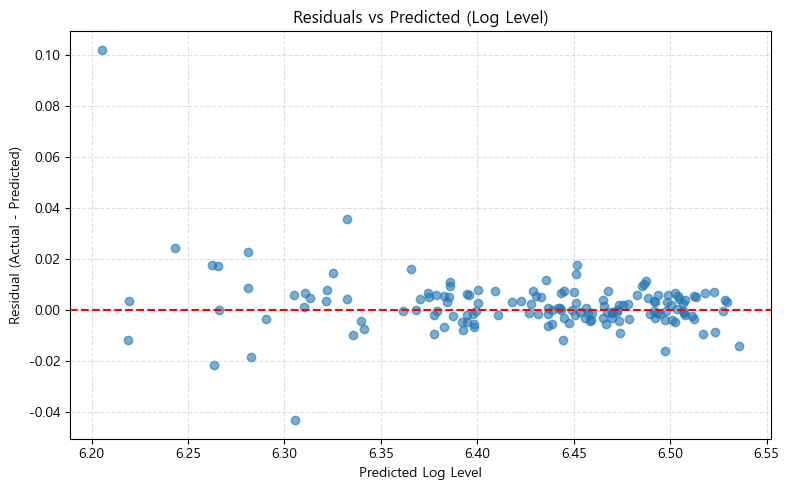

In [20]:
# ============================================================
# 3) Residuals vs Predicted Plot (log-level 기준)
# ============================================================

plt.figure(figsize=(8, 5))
plt.scatter(log_pred_seq, residuals_log, alpha=0.6)

plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residuals vs Predicted (Log Level)")
plt.xlabel("Predicted Log Level")
plt.ylabel("Residual (Actual - Predicted)")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import numpy as np
import pandas as pd

# 1) 모델 로드
model = joblib.load("../../modeling/Model/다중회귀_best.joblib")

# 2) 피처 이름 (학습 때 쓰던 X의 columns 그대로 넣어줘야 함)
feature_names = [
 'GC=F_Volume','^VIX_Volatility','GC=F_Volatility','SHY_Volatility','SPY_Premium_pct'
    # ...
]


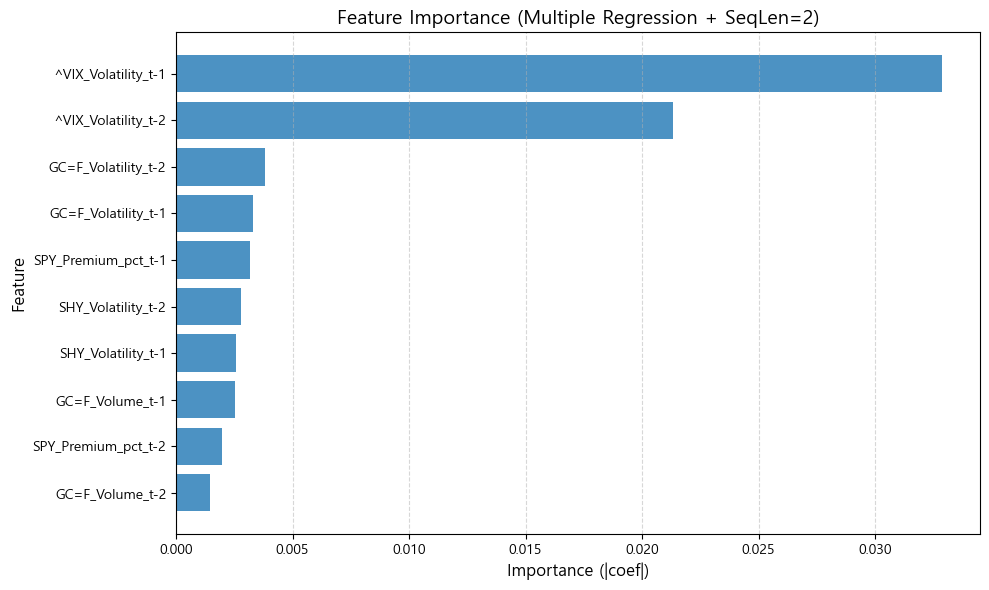

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) coef + 확장 피처 이름 준비
# -------------------------------
coefs = model.coef_.ravel()  # (10,)
orig_features = feature_names  # 원본 5개
SEQ_LEN = 2

# 시퀀스 확장 피처 이름 생성
expanded_features = []
for t in range(SEQ_LEN):
    for f in orig_features:
        expanded_features.append(f"{f}_t-{SEQ_LEN - t}")

# -------------------------------
# 2) 중요도 DataFrame
# -------------------------------
importance_df = pd.DataFrame({
    "feature": expanded_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# -------------------------------
# 3) 바 그래프 시각화
# -------------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df["feature"], 
    importance_df["abs_coef"], 
    alpha=0.8
)

plt.xlabel("Importance (|coef|)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance (Multiple Regression + SeqLen=2)", fontsize=14)
plt.gca().invert_yaxis()   # 중요도가 큰 것 위로 오게 설정

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
importance_df

,feature,coef,abs_coef
6,^VIX_Volatility_t-1,-0.032859,0.032859
1,^VIX_Volatility_t-2,0.021306,0.021306
2,GC=F_Volatility_t-2,-0.003802,0.003802
7,GC=F_Volatility_t-1,0.003318,0.003318
9,SPY_Premium_pct_t-1,0.003164,0.003164
3,SHY_Volatility_t-2,0.002794,0.002794
8,SHY_Volatility_t-1,0.002586,0.002586
5,GC=F_Volume_t-1,-0.002529,0.002529
4,SPY_Premium_pct_t-2,0.001985,0.001985
0,GC=F_Volume_t-2,0.001476,0.001476


In [ ]:
import pandas as pd
import numpy as np

importance_df = pd.DataFrame({
    "feature": expanded_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
})

# 원본 피처명 추출 (t-1, t-2 제거)
importance_df["base_feature"] = importance_df["feature"].str.replace("_t-1", "").str.replace("_t-2", "")

# 원본 피처별로 중요도 합산
grouped_importance = (
    importance_df.groupby("base_feature")["abs_coef"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print(grouped_importance)


      base_feature  abs_coef
0  ^VIX_Volatility  0.054165
1  GC=F_Volatility  0.007121
2   SHY_Volatility  0.005380
3  SPY_Premium_pct  0.005149
4      GC=F_Volume  0.004005
